## Importing Modules and Initializing Parameters

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, linalg
from scipy.sparse.linalg import spsolve
import os
from numba import njit,prange



Lx = 20.0       
Ly = 10.0      
Nx = 384      
Ny = 192       


dx = Lx / Nx    
dy = Ly / Ny    
aspect_ratio = dx / dy


Re = 200.0     
nu = 1.0 / Re   
rho = 1.0       


dt = 0.001     
T_final = 30.0 
n_steps = int(T_final / dt)


save_interval = 100   # Saving visualization every N steps
output_dir = "results"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)




### Prepare Data strcuture

In [90]:


u = np.ones((Ny, Nx + 1))  
v = np.zeros((Ny + 1, Nx))






p = np.zeros((Ny, Nx))

# intermediate velocities (for chlorins projection method)
u_star = np.zeros_like(u)
v_star = np.zeros_like(v)


# IBM stuffs

#pressure indices
x_center = np.linspace(dx/2, Lx - dx/2, Nx)
y_center = np.linspace(dy/2, Ly - dy/2, Ny)
X_p, Y_p = np.meshgrid(x_center, y_center)

# U indices
x_u_faces = np.linspace(0, Lx, Nx + 1)
X_u, Y_u = np.meshgrid(x_u_faces, y_center)

# V indices
y_v_faces = np.linspace(0, Ly, Ny + 1)
X_v, Y_v = np.meshgrid(x_center, y_v_faces)


print(f"u shape: {u.shape}")
print(f"v shape: {v.shape}")
print(f"p shape: {p.shape}")


u shape: (192, 385)
v shape: (193, 384)
p shape: (192, 384)


## Applying velocity B.C.


In [91]:


@njit(cache=True, fastmath=True)
def apply_boundary_conditions(u, v, u_inlet, v_inlet):
    
   
    u[:, 0] = u_inlet  
    v[:, 0] = v_inlet  
    
  
    u[:, -1] = u[:, -2]
    v[:, -1] = v[:, -2]
    
    
    v[0, :] = 0.0   
    v[-1, :] = 0.0  
    
    return u, v


## Computing Advection term

In [92]:


@njit(parallel=True, fastmath=True)
def compute_advection(u, v, dx, dy):
    ny, nx_u = u.shape
    ny_v, nx = v.shape
    
    adv_u = np.zeros((ny-2, nx_u-2))
    adv_v = np.zeros((ny_v-2, nx-2))
    
    for i in prange(1, ny-1):
        for j in range(1, nx_u-1):
        
            v_at_u = 0.25 * (v[i-1, j-1] + v[i, j-1] + v[i-1, j] + v[i, j])
            
            # using Upwind 
            if u[i, j] > 0:
                du_dx = (u[i, j] - u[i, j-1]) / dx
            else:
                du_dx = (u[i, j+1] - u[i, j]) / dx
                
            # using upwind
            if v_at_u > 0:
                du_dy = (u[i, j] - u[i-1, j]) / dy
            else:
                du_dy = (u[i+1, j] - u[i, j]) / dy
            
            adv_u[i-1, j-1] = u[i, j] * du_dx + v_at_u * du_dy


    for i in prange(1, ny_v-1):
        for j in range(1, nx-1):
            
            u_at_v = 0.25 * (u[i-1, j] + u[i, j] + u[i-1, j+1] + u[i, j+1])
            
            # Again, using upwind
            if u_at_v > 0:
                dv_dx = (v[i, j] - v[i, j-1]) / dx
            else:
                dv_dx = (v[i, j+1] - v[i, j]) / dx
                
            
            if v[i, j] > 0:
                dv_dy = (v[i, j] - v[i-1, j]) / dy
            else:
                dv_dy = (v[i+1, j] - v[i, j]) / dy
                
            adv_v[i-1, j-1] = u_at_v * dv_dx + v[i, j] * dv_dy
            
    return adv_u, adv_v


## Computing Diffusion

In [93]:
@njit(parallel=True, fastmath=True)
def compute_diffusion(u, v, dx, dy, nu):
    ny_u, nx_u = u.shape
    ny_v, nx_v = v.shape
    
    diff_u = np.zeros((ny_u-2, nx_u-2))
    diff_v = np.zeros((ny_v-2, nx_v-2))
    
    idx2 = 1.0 / (dx*dx)
    idy2 = 1.0 / (dy*dy)
    
    for i in prange(1, ny_u-1):
        for j in range(1, nx_u-1):
            u_xx = (u[i, j+1] - 2*u[i, j] + u[i, j-1]) * idx2
            u_yy = (u[i+1, j] - 2*u[i, j] + u[i-1, j]) * idy2
            diff_u[i-1, j-1] = u_xx + u_yy
            
    for i in prange(1, ny_v-1):
        for j in range(1, nx_v-1):
            v_xx = (v[i, j+1] - 2*v[i, j] + v[i, j-1]) * idx2
            v_yy = (v[i+1, j] - 2*v[i, j] + v[i-1, j]) * idy2
            diff_v[i-1, j-1] = v_xx + v_yy
            
    return diff_u, diff_v


## Computing Divergence

In [94]:
@njit(parallel=True, fastmath=True)
def compute_divergence(u, v, dx, dy):
    
    ny, nx = u.shape[0], v.shape[1]
    div = np.zeros((ny, nx))
    
   
    for i in prange(ny):
        for j in range(nx):
            
            div[i, j] = (u[i, j+1] - u[i, j]) * (1.0 / dx) + \
                        (v[i+1, j] - v[i, j]) * (1.0 / dy)
            
    return div

## Building Pressure Matrix

In [95]:

from scipy.sparse import coo_matrix

def build_pressure_matrix(Nx, Ny, dx, dy):
    cx = 1.0 / (dx**2)
    cy = 1.0 / (dy**2)
    N = Nx * Ny
    
   
    rows = []
    cols = []
    data = []
    
    
    def add_entry(r, c, val):
        rows.append(r)
        cols.append(c)
        data.append(val)
    
    
    indices = np.indices((Nx, Ny)).transpose(2, 1, 0).reshape(-1, 2)
    
    def k(i, j): 
        return j * Nx + i

    
    row_idx = 0
    for i, j in indices:
        
        
        
        if i == 0 and j == 0:
            add_entry(row_idx, k(0, 0), 1.0)
            row_idx += 1
            continue

        
    
        add_entry(row_idx, k(i, j), -2*(cx + cy))
        
        
        
        if i == 0:
            
            add_entry(row_idx, k(0, j), cx)  
            add_entry(row_idx, k(1, j), cx)   
        elif i == Nx - 1:
            add_entry(row_idx, k(Nx-1, j), cx) 
            add_entry(row_idx, k(Nx-2, j), cx) 
        else:
           
            add_entry(row_idx, k(i-1, j), cx)
            add_entry(row_idx, k(i+1, j), cx)

    
        if j == 0:
            add_entry(row_idx, k(i, 0), cy) 
            add_entry(row_idx, k(i, 1), cy)   
        elif j == Ny - 1:
            add_entry(row_idx, k(i, Ny-1), cy) 
            add_entry(row_idx, k(i, Ny-2), cy) 
        else :
            add_entry(row_idx, k(i, j-1), cy)
            add_entry(row_idx, k(i, j+1), cy)
            
        row_idx += 1

   
    A_sparse = coo_matrix((data, (rows, cols)), shape=(N, N))
    
    
    return A_sparse.tocsc()


A = build_pressure_matrix(Nx, Ny, dx, dy)

In [96]:

pressure_solver = linalg.factorized(A)

def solve_pressure(b):
  
    b[0] = 0
    
    p_flat = pressure_solver(b)
    
    return p_flat.reshape((Ny, Nx))

print("Done")


Done


**NOTE :** The following code has same logic, but won't run
```python
from scipy.sprase import csc_matrix

def build_pressure_matrix(Nx,Ny,dx,dy) :
    cx = 1/(dx**2)
    cy = 1/(dy**2)
    N = Nx * Ny
    
    A = np.zeros((N,N))
    
    indices = np.indices((Nx,Ny)).transpose(2,1,0).reshape(-1,2)
    
    
    row_index = 0 
    for i,j in indices :
        
        row = A[row_index]
        
        row_index += 1
    
        def k(i,j) : return j * Nx + i 
        
        row[k(i,j)] = -2*(cx+cy)

        
        if i == 0 :
            # p-1,j = p0,j 
            row[k(0,j)] += cx
            row[k(1,j)] = cx
            
        elif i == Nx - 1 :
            # pNx-1,j = 0 
            row[k(Nx-1,j)] = 1
            continue
        else :
            row[k(i-1,j)] = cx
            row[k(i+1,j)] = cx
        
        if j == 0 :
            #pi,-1 = pi,0
            row[k(i,0)] += cy
            row[k(i,1)] = cy
        elif j == Ny - 1 :
            #pi,Ny-1 = pi,Ny 
            row[k(i,Ny-1)] += cy
            row[k(i,Ny-2)] = cy
        else :
            row[k(i,j-1)] = cy
            row[k(i,j+1)] = cy 
        

        
    return csc_matrix


```


because without using SciPy compressed matrix format, it wastes huge space storing many zeroes (Since this pressure matrix is very sparse). It will show MemoryError as given below : 

---------------------------------------------------------------------------
MemoryError                               Traceback (most recent call last)
Cell In[29], line 59
     49             row[k(i,j+1)] = cy 
     56     return csc_matrix(A) # converting it to scipy's compressed sparse matrix format
---> 59 A = build_pressure_matrix(Nx, Ny, dx, dy)

Cell In[29], line 9, in build_pressure_matrix(Nx, Ny, dx, dy)
      6 cy = 1/(dy**2)
      7 N = Nx * Ny
----> 9 A = np.zeros((N,N))
     11 indices = np.indices((Nx,Ny)).transpose(2,1,0).reshape(-1,2)
     14 row_index = 0 

MemoryError: Unable to allocate 40.5 GiB for an array with shape (73728, 73728) and data type float64

## Veloicty correction step (from Chlorin's projection Method)

In [97]:
@njit(parallel=True, fastmath=True)
def correct_velocity(u, v, p, dt, dx, dy):
    ny, nx = p.shape
    dt_dx = dt / dx
    dt_dy = dt / dy
    
    
    for i in prange(ny):
        for j in range(1, nx):
            u[i, j] -= dt_dx * (p[i, j] - p[i, j-1])
            
    
    for i in prange(1, ny):
        for j in range(nx):
            v[i, j] -= dt_dy * (p[i, j] - p[i-1, j])
            
    return u, v


## Immersed Boundary Method

#### Defining Geometry

In [98]:


cx, cy = 4.0, 5.0  
D = 1.0            
R = D / 2.0        


N_ib = 200

theta = np.linspace(0, 2*np.pi, N_ib, endpoint=False)
X_ib = cx + R * np.cos(theta)
Y_ib = cy + R * np.sin(theta)


U_ib_target = np.zeros(N_ib)
V_ib_target = np.zeros(N_ib)




#### Calculating Bilinear weights

In [99]:
@njit(fastmath=True)
def get_bilinear_weights(X_pts, Y_pts, x_grid_start, y_grid_start, dx, dy):
    # Normalized position
    x_norm = (X_pts - x_grid_start) / dx
    y_norm = (Y_pts - y_grid_start) / dy
    
    i0 = np.floor(x_norm).astype(np.int32)
    j0 = np.floor(y_norm).astype(np.int32)
    
    wx = x_norm - i0
    wy = y_norm - j0
    return i0, j0, wx, wy

#### Interpolating velocity, Calculating Force at Immersed Boundary (IB) and spreading it

In [100]:
@njit(parallel=True, fastmath=True)
def interpolate_velocity(u, v, X_ib, Y_ib, dx, dy):
    N_pts = len(X_ib)
    U_ib = np.zeros(N_pts)
    V_ib = np.zeros(N_pts)
    
    
    i_u, j_u, wx_u, wy_u = get_bilinear_weights(X_ib, Y_ib, 0, dy/2, dx, dy)
    
    i_v, j_v, wx_v, wy_v = get_bilinear_weights(X_ib, Y_ib, dx/2, 0, dx, dy)
    
    for k in prange(N_pts):
        # U interpolation
        U_ib[k] = (1-wx_u[k])*(1-wy_u[k]) * u[j_u[k], i_u[k]] + \
                   wx_u[k]*(1-wy_u[k])    * u[j_u[k], i_u[k]+1] + \
                   (1-wx_u[k])*wy_u[k]    * u[j_u[k]+1, i_u[k]] + \
                   wx_u[k]*wy_u[k]        * u[j_u[k]+1, i_u[k]+1]
        
        # V interpolation
        V_ib[k] = (1-wx_v[k])*(1-wy_v[k]) * v[j_v[k], i_v[k]] + \
                   wx_v[k]*(1-wy_v[k])    * v[j_v[k], i_v[k]+1] + \
                   (1-wx_v[k])*wy_v[k]    * v[j_v[k]+1, i_v[k]] + \
                   wx_v[k]*wy_v[k]        * v[j_v[k]+1, i_v[k]+1]
                   
    return U_ib, V_ib



@njit(fastmath=True) 
def compute_ib_force(u, v, X_ib, Y_ib, U_targ, V_targ, dt, dx, dy):
    
    u_interp, v_interp = interpolate_velocity(u, v, X_ib, Y_ib, dx, dy)
    
    
    alpha = 0.8
    
   
    fx_ib = alpha * (U_targ - u_interp) / dt
    fy_ib = alpha * (V_targ - v_interp) / dt
    
   
    area = dx*dy
    fx_ib *= area
    fy_ib *= area
    
    return fx_ib, fy_ib





@njit(fastmath=True) 
def spread_force(fx_ib, fy_ib, X_ib, Y_ib, ny_u, nx_u, ny_v, nx_v, dx, dy):
    fx = np.zeros((ny_u, nx_u))
    fy = np.zeros((ny_v, nx_v))
    
    N_pts = len(X_ib)
    
    # Spread Fx to U-grid
    i0, j0, wx, wy = get_bilinear_weights(X_ib, Y_ib, 0, dy/2, dx, dy)
    for k in range(N_pts):
        fx[j0[k], i0[k]]     += (1-wx[k])*(1-wy[k]) * fx_ib[k]
        fx[j0[k], i0[k]+1]   += wx[k]*(1-wy[k])     * fx_ib[k]
        fx[j0[k]+1, i0[k]]   += (1-wx[k])*wy[k]     * fx_ib[k]
        fx[j0[k]+1, i0[k]+1] += wx[k]*wy[k]         * fx_ib[k]

    # Spread Fy to V-grid
    i0, j0, wx, wy = get_bilinear_weights(X_ib, Y_ib, dx/2, 0, dx, dy)
    for k in range(N_pts):
        fy[j0[k], i0[k]]     += (1-wx[k])*(1-wy[k]) * fy_ib[k]
        fy[j0[k], i0[k]+1]   += wx[k]*(1-wy[k])     * fy_ib[k]
        fy[j0[k]+1, i0[k]]   += (1-wx[k])*wy[k]     * fy_ib[k]
        fy[j0[k]+1, i0[k]+1] += wx[k]*wy[k]         * fy_ib[k]
    

    area = dx*dy

    return fx*(1/area) , fy*(1/area)


#### Defining functions for Data Visualization

for velocity

In [101]:
def plot_velocity_field(u, v, X_ib, Y_ib, step, Lx, Ly, dx, dy, output_dir):
    
    u_avg = 0.5 * (u[:, :-1] + u[:, 1:])
    v_avg = 0.5 * (v[:-1, :] + v[1:, :])  
    
    
    speed = np.sqrt(u_avg**2 + v_avg**2)
    
    
    plt.figure(figsize=(12, 5))
    
    
    im = plt.imshow(speed, origin='lower', extent=[0, Lx, 0, Ly], 
                    cmap='viridis', interpolation='bilinear')
    plt.colorbar(im, label="Velocity Magnitude (m/s)")
    
    # For streamlines
    x_c = np.linspace(dx/2, Lx - dx/2, Nx)
    y_c = np.linspace(dy/2, Ly - dy/2, Ny)
    Xc, Yc = np.meshgrid(x_c, y_c)
    
   
    plt.streamplot(Xc, Yc, u_avg, v_avg, color='white', density=1.2, 
                   linewidth=0.8, arrowsize=0.8)
    
    # filling the cylinder black
    plt.fill(X_ib, Y_ib, color='black')
    
    plt.title(f"Velocity Magnitude : Step {step} and time {step*dt}")
    plt.xlabel("X")
    plt.ylabel("Y")
    
    plt.savefig(f"{output_dir}/velocity_{step:06d}.png", dpi=150)
    plt.close()


for voriticity

In [ ]:


def plot_vorticity_frame(u, v, X_ib, Y_ib, step, Lx, Ly, dx, dy, output_dir):
    
    # using vorticity formula omega = dv/dx - du/dy
    dv_dx = (v[1:-1, 1:] - v[1:-1, :-1]) / dx
    du_dy = (u[1:, 1:-1] - u[:-1, 1:-1]) / dy
    omega = dv_dx - du_dy
    
    
    plt.figure(figsize=(12, 6))
    
    # 'RdBu_r' gives blue (clockwise or negative) and red (counter-clockwise or positive) vortices
    plt.imshow(omega, origin='lower', cmap='RdBu_r', vmin=-3, vmax=3, # (-5,5) was default
               extent=[0, Lx, 0, Ly], interpolation='bilinear')
    
    plt.colorbar(label="Vorticity (1/s)", fraction=0.02, pad=0.04)
    
    # Again filling the cylinder with black colour
    plt.fill(X_ib, Y_ib, color='black', label="Cylinder")
    
    plt.title(f"Navier-Stokes | Vortex Shedding at Step {step}")
    plt.xlabel("Channel Length (x)")
    plt.ylabel("Channel Height (y)")
    plt.xlim(0, Lx)
    plt.ylim(0, Ly)
    
  
    plt.savefig(f"{output_dir}/vorticity_{step:06d}.png", dpi=150)
    plt.close()


### Initial velocity conditions

In [103]:
angle_rad = np.deg2rad(2.5)
u_in_val = 1.0 * np.cos(angle_rad)
v_in_val = 1.0 * np.sin(angle_rad)

### For Storing drag and lift forces history

In [104]:

history_lift = np.zeros(n_steps)
history_drag = np.zeros(n_steps)


#### Making Data structure of Dataset for PINN (not covered in this Repo)


In [105]:
pinn_save_interval = 1000
n_pinn_snapshots = n_steps // pinn_save_interval
pinn_data_u = np.zeros((n_pinn_snapshots, Ny, Nx+1), dtype=np.float32)
pinn_data_v = np.zeros((n_pinn_snapshots, Ny+1, Nx), dtype=np.float32)
pinn_data_p = np.zeros((n_pinn_snapshots, Ny, Nx), dtype=np.float32)

## Main Time-Stepping Loop

In [106]:

print(f"Running for {n_steps} steps...")

for step in range(n_steps):
    
    adv_u, adv_v = compute_advection(u, v, dx, dy)
    diff_u, diff_v = compute_diffusion(u, v, dx, dy, nu)
    
    
    u_star[:] = u[:] 
    v_star[:] = v[:]
    u_star[1:-1, 1:-1] += dt * (-adv_u + (1/Re)*diff_u)
    v_star[1:-1, 1:-1] += dt * (-adv_v + (1/Re)*diff_v)
    
    
    u_star, v_star = apply_boundary_conditions(u_star, v_star, u_in_val, v_in_val)
    
    
    Fx_ib, Fy_ib = compute_ib_force(u_star, v_star, X_ib, Y_ib, 0.0, 0.0, dt, dx, dy)
    
    
    fx_grid, fy_grid = spread_force(Fx_ib, Fy_ib, X_ib, Y_ib, Ny, Nx+1, Ny+1, Nx, dx, dy)
    
    
    u_star += dt * fx_grid
    v_star += dt * fy_grid
    
    
    div_u_star = compute_divergence(u_star, v_star, dx, dy)
    rhs = div_u_star.flatten() / dt
    p = solve_pressure(rhs)
    
    
    u, v = correct_velocity(u_star, v_star, p, dt, dx, dy)
    u, v = apply_boundary_conditions(u, v, u_in_val, v_in_val)
    
    
    history_drag[step] = -np.sum(Fx_ib) 
    history_lift[step] = -np.sum(Fy_ib)
    
    # Saving Data for PINN
    if step % pinn_save_interval == 0:
        idx = step // pinn_save_interval
        pinn_data_u[idx] = u.astype(np.float32) 
        pinn_data_v[idx] = v.astype(np.float32)
        pinn_data_p[idx] = p.astype(np.float32)
        
        
       
        
    if step % 100 == 0:
        print(f"Step {step}/{n_steps} | Lift = {history_lift[step]:.4f} | Max u = {np.max(u):.3f} & Max v = {np.max(v):.3f}")
        plot_velocity_field(u, v, X_ib, Y_ib, step, Lx, Ly, dx, dy, output_dir)
        plot_vorticity_frame(u, v, X_ib, Y_ib, step, Lx, Ly, dx, dy, output_dir)


np.savez_compressed("pinn_dataset_vortex.npz", u=pinn_data_u, v=pinn_data_v, p=pinn_data_p, dt=dt)
print("Simulation Completed andd PINN dataset saved.")


Running for 30000 steps...
Step 0/30000 | Lift = -0.0000 | Max u = 1.200 & Max v = 1.073
Step 100/30000 | Lift = -0.1190 | Max u = 1.644 & Max v = 0.779
Step 200/30000 | Lift = -0.1090 | Max u = 1.614 & Max v = 0.734
Step 300/30000 | Lift = -0.1121 | Max u = 1.588 & Max v = 0.719
Step 400/30000 | Lift = -0.1193 | Max u = 1.570 & Max v = 0.709
Step 500/30000 | Lift = -0.1273 | Max u = 1.546 & Max v = 0.702
Step 600/30000 | Lift = -0.1354 | Max u = 1.537 & Max v = 0.696
Step 700/30000 | Lift = -0.1433 | Max u = 1.527 & Max v = 0.691
Step 800/30000 | Lift = -0.1510 | Max u = 1.515 & Max v = 0.686
Step 900/30000 | Lift = -0.1580 | Max u = 1.502 & Max v = 0.682
Step 1000/30000 | Lift = -0.1644 | Max u = 1.495 & Max v = 0.678
Step 1100/30000 | Lift = -0.1702 | Max u = 1.489 & Max v = 0.675
Step 1200/30000 | Lift = -0.1753 | Max u = 1.482 & Max v = 0.672
Step 1300/30000 | Lift = -0.1794 | Max u = 1.476 & Max v = 0.669
Step 1400/30000 | Lift = -0.1826 | Max u = 1.469 & Max v = 0.667
Step 1500/

## Finalizing the Simulation by Calculating

Cd (Drag coefficient)

cl (Lift coefficient)

St (Strouhal Number)


In [111]:

def finalize_simulation(history_drag, history_lift, dt, D, U_inf=1.0):
    
    history_drag = np.array(history_drag)
    history_lift = np.array(history_lift)
    
    
    Cd = 2.0 * history_drag
    Cl = 2.0 * history_lift
    
   
    # Use Fast Fourier Transform (FFT) on the lift history (ignoring the startup)
    n_cutoff = int(len(Cl) * 0.33)
    Cl_steady = Cl[n_cutoff:]

    Cl_steady = Cl_steady - np.mean(Cl_steady)
    
    n_padded = len(Cl_steady) * 10
    freqs = np.fft.rfftfreq(n_padded, d=dt)
    fft_vals = np.abs(np.fft.rfft(Cl_steady,n=n_padded))
    
    
    f_shedding = freqs[np.argmax(fft_vals[1:]) + 1] # Skip 0-frequency (mean)
    St = f_shedding * D / U_inf
    

    print(f"Mean Drag Coefficient (Cd): {np.mean(Cd):.4f}")
    print(f"Max Lift Coefficient (Cl): {np.max(Cl):.4f}")
    print(f"Strouhal Number (St): {St:.4f}")
    
    return Cd, Cl, St


### Visualizing Cl (lift coefficient) vs. time-steps

Mean Drag Coefficient (Cd): 1.6743
Max Lift Coefficient (Cl): 0.6373
Strouhal Number (St): 0.1592


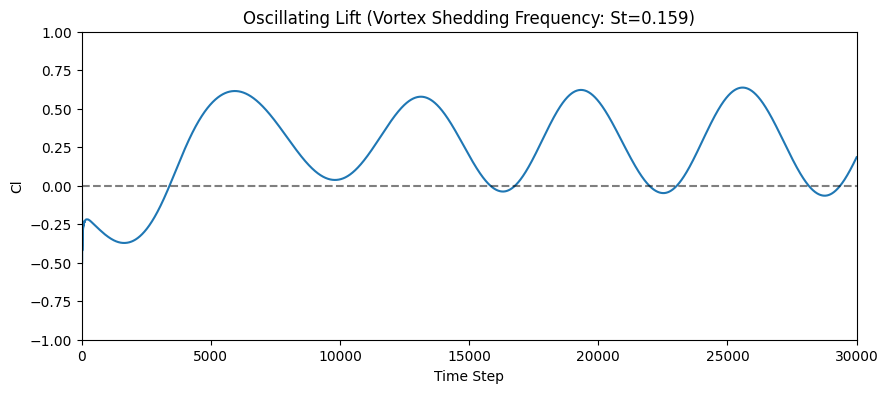

In [112]:

Cd_history, Cl_history, St = finalize_simulation(history_drag, history_lift, dt, D=1.0)


time = np.linspace(0,T_final,int(T_final/dt))



plt.figure(figsize=(10, 4))
plt.plot(Cl_history, label="Lift Coefficient (Cl)")
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.title(f"Oscillating Lift (Vortex Shedding Frequency: St={St:.3f})")

plt.xlabel("Time Step")
plt.ylabel("Cl")


ax = plt.gca()
ax.set_ylim(-1, 1)
ax.set_xlim(0,n_steps)


plt.show()


In [109]:
print(len(Cl_history))

30000


## Saving a video of our simulation

In [110]:
import cv2
import os


image_folder = 'results' 
video_name = 'vortex_shedding_codecavc1.mp4'
fps = 10
start_step = 0
step_size = 100
end_step = n_steps - step_size



first_img_path = os.path.join(image_folder, f"vorticity_{start_step:06d}.png")
frame = cv2.imread(first_img_path)
height, width, layers = frame.shape


fourcc = cv2.VideoWriter_fourcc(*'avc1') 
video = cv2.VideoWriter(video_name, fourcc, fps, (width, height))



for step in range(start_step, end_step + step_size, step_size):
    img_path = os.path.join(image_folder, f"vorticity_{step:06d}.png")
    
    if os.path.exists(img_path):
        video.write(cv2.imread(img_path))
    else:
        os.mkdir(img_path)
        video.write(cv2.imread(img_path))


video.release()

print("Done :) ")

Done :) 
